In [7]:
### import libraries

import numpy as np
import pandas as pd
from policy_mining import PolicyMining
import matplotlib.pyplot as plt

In [6]:
NAME_DATASET = "AMZ"
FILE_NAME = None
USER_ATTRS = None
RESOURCE_ATTRS = None
th_rule_sim = None

# Settings for each dataset
if NAME_DATASET == "AMZ":
    FILE_NAME = "../../00-Data/train.csv"
    USER_ATTRS = ["MGR_ID", "ROLE_ROLLUP_1", "ROLE_ROLLUP_2", "ROLE_DEPTNAME",
                  "ROLE_TITLE", "ROLE_FAMILY_DESC", "ROLE_FAMILY", "ROLE_CODE"]
    RESOURCE_ATTRS = ["RID"]
    th_rule_sim = 1

elif NAME_DATASET == "HC":
    FILE_NAME = "../../00-Data/HC-AccessLog.csv"
    USER_ATTRS = ['role', 'specialty', 'team', 'uward', 'agentfor']
    RESOURCE_ATTRS = ['type', 'patient', 'treatingteam',
                      'oward', 'author', 'topic']
    th_rule_sim = 2

elif NAME_DATASET == "CAV":
    FILE_NAME = "../00-Data/CAV.csv"
else:
    print("Invalid Dataset")

pm = PolicyMining(FILE_NAME, NAME_DATASET, USER_ATTRS, RESOURCE_ATTRS)
pm.data_preprocessing()

File loaded! 



Cross-Validation - DONE
- k = 10
- Percentage Train-Test: 80.0 - 20.0
# Access requests in Train: 26215  %: 80.00
# Access requests in Test: 6554  %: 20.00
# Access requests: 32769


##############################
 PHASE 1: Data Preprocessing.
##############################


TASK 1: Done!

TASK 2: Done!

BEFORE
# (+) access requests: 24697  %: 94.21
# (-) access requests: 1518  %: 5.79
AFTER
# (+) access requests: 24697  %: 94.21
# (-) access requests: 1518  %: 5.79
TASK 3: Done!

|U|:  8826  -	|R|:  6670


In [2]:
def resize_distribution(prob_distribution, new_size):
    """
    Resize the probability distribution to a new size using linear interpolation.

    Parameters:
    - prob_distribution (list): The original probability distribution.
    - new_size (int): The desired size of the new probability distribution.

    Returns:
    - list: The resized probability distribution.
    """
    old_size = len(prob_distribution)

    # Create indices for the old and new arrays
    old_indices = np.linspace(0, old_size - 1, old_size)
    new_indices = np.linspace(0, old_size - 1, new_size)

    # Use linear interpolation to resize the distribution
    resized_distribution = np.interp(new_indices, old_indices, prob_distribution)

    # Normalize the distribution to ensure it sums to 1
    resized_distribution /= sum(resized_distribution)

    return resized_distribution

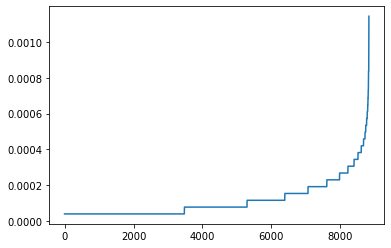

In [8]:
### USER Frequency distribution

to_plot = pm.df_train_k["UID"].value_counts(normalize=True, ascending=True)
plt.plot(range(len(to_plot)), to_plot)

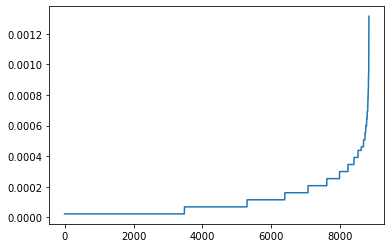

In [18]:
### USER Frequency distribution --- NEW DATASET 50K

to_plot = new_acc_log["UID"].value_counts(normalize=True, ascending=True)
plt.plot(range(len(to_plot)), to_plot)

In [12]:
pm.df_train_k["UID"].unique()

array(['ID-U-17261', 'ID-U-16696', 'ID-U-5664', ..., 'ID-U-32117',
       'ID-U-2831', 'ID-U-2022'], dtype=object)

In [10]:
n_bins = pm.n_users # number of Users to map. In this case the same number
test = list(to_plot.values)
resized_distribution = resize_distribution(test, n_bins)
print("Original Distribution:", test)
print("Resized Distribution:", resized_distribution)

Original Distribution: [3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.814609956131986e-05, 3.81460995

In [13]:
df_user_prob = pd.DataFrame({"UID": pm.df_train_k["UID"].unique(), "prob": resized_distribution})
df_user_prob.head()

,UID,prob
0,ID-U-17261,0.000038
1,ID-U-16696,0.000038
2,ID-U-5664,0.000038
3,ID-U-4784,0.000038
4,ID-U-28797,0.000038


In [ ]:
import pandas as pd

def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """
    Sample a DataFrame based on a given distribution.

    Parameters:
    - access_log (pd.DataFrame): The original DataFrame containing access log data.
    - sample_size (int): The desired size of the resulting sample.
    - prob_distri (pd.DataFrame): A DataFrame with two columns - 'class_name' and 'probability'.
                                 It represents the distribution of classes and their corresponding probabilities.
    - class_name (str): The column name in 'access_log' representing the classes.

    Returns:
    - pd.DataFrame: A DataFrame containing the sampled data based on the specified distribution.
    """

    # Initialize an empty DataFrame to store the sampled access requests
    new_sample = pd.DataFrame()

    # Iterate through each class and sample data based on the provided distribution
    for i in prob_distri.iloc:
        # Filter the original DataFrame for the current class
        temp = access_log[access_log[class_name] == i[0]]

        # Calculate the number of samples based on the probability and desired sample size
        n_samples = int(i[1] * sample_size)

        # Sample data for the current class with replacement
        temp = temp.sample(n=n_samples, replace=True)

        # Concatenate the sampled data to the new_sample DataFrame
        new_sample = pd.concat([new_sample, temp])

    return new_sample


In [14]:
def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """ Sampling a dataframe based on a given distribution. """
    new_sample = pd.DataFrame() # Store all access requests
    for i in prob_distri.iloc:
        temp = access_log[access_log[class_name]==i[0]]
        n_samples = int(i[1]*sample_size)        
        temp = temp.sample(n=n_samples, replace=True)
        new_sample = pd.concat([new_sample, temp])

    return new_sample

In [17]:
### Get sample distribution
acc_log = pm.df_train_k
numbers_of_acc_reqs = 50000
new_acc_log = get_sample_by_distribution(acc_log, numbers_of_acc_reqs, df_user_prob, "UID")
print("*** Done! ***")
print(new_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43369 entries, 28349 to 2022
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ACTION            43369 non-null  int64 
 1   RID               43369 non-null  int64 
 2   MGR_ID            43369 non-null  int64 
 3   ROLE_ROLLUP_1     43369 non-null  int64 
 4   ROLE_ROLLUP_2     43369 non-null  int64 
 5   ROLE_DEPTNAME     43369 non-null  int64 
 6   ROLE_TITLE        43369 non-null  int64 
 7   ROLE_FAMILY_DESC  43369 non-null  int64 
 8   ROLE_FAMILY       43369 non-null  int64 
 9   ROLE_CODE         43369 non-null  int64 
 10  UID               43369 non-null  object
dtypes: int64(10), object(1)
memory usage: 4.0+ MB
None


In [25]:
### Get sample distribution
acc_log = pm.df_train_k
numbers_of_acc_reqs = 50000
df_user_prob = pm.df_train_k["UID"].value_counts(normalize=True)
df_user_prob = pd.DataFrame({"UID": new_acc_log["UID"].unique(), "prob": df_user_prob})
new_acc_log = get_sample_by_distribution(acc_log, numbers_of_acc_reqs, df_user_prob, "UID")
print("*** Done! ***")
print(new_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43369 entries, 32246 to 2022
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ACTION            43369 non-null  int64 
 1   RID               43369 non-null  int64 
 2   MGR_ID            43369 non-null  int64 
 3   ROLE_ROLLUP_1     43369 non-null  int64 
 4   ROLE_ROLLUP_2     43369 non-null  int64 
 5   ROLE_DEPTNAME     43369 non-null  int64 
 6   ROLE_TITLE        43369 non-null  int64 
 7   ROLE_FAMILY_DESC  43369 non-null  int64 
 8   ROLE_FAMILY       43369 non-null  int64 
 9   ROLE_CODE         43369 non-null  int64 
 10  UID               43369 non-null  object
dtypes: int64(10), object(1)
memory usage: 4.0+ MB
None


In [22]:
len(new_acc_log.drop_duplicates()), len(new_acc_log["UID"].unique())

(12025, 8826)

In [26]:
len(new_acc_log.drop_duplicates()), len(new_acc_log["UID"].unique())

(18594, 8826)

In [23]:
len(pm.df_train_k.drop_duplicates()), len(pm.df_train_k["UID"].unique())

(26215, 8826)

In [27]:
### Generación de los access logs con ruido

def randomly_change_column_value(dataframe, column_name, change_percentage, new_value):
    """
    Randomly change a percentage of rows in a DataFrame by modifying a specific column's value.

    Parameters:
    - dataframe (pd.DataFrame): The original DataFrame.
    - column_name (str): The name of the column to be modified.
    - change_percentage (float): The percentage of rows to be randomly selected and modified (0 to 1).
    - new_value: The new value to be assigned to the selected rows in the specified column.

    Returns:
    - pd.DataFrame: A new DataFrame with the specified changes.
    """

    # Copy the original DataFrame to avoid modifying the input directly
    modified_dataframe = dataframe.copy()

    # Calculate the number of rows to be changed based on the specified percentage
    num_rows_to_change = int(change_percentage * len(dataframe))

    # Randomly select rows to be modified
    selected_rows = np.random.choice(dataframe.index, size=num_rows_to_change, replace=False)

    # Change the specified column's value in the selected rows
    modified_dataframe.loc[selected_rows, column_name] = new_value

    return modified_dataframe

In [ ]:
import pandas as pd
import numpy as np

def randomly_change_column_value_with_distribution(dataframe, column_name, probability_column, new_value):
    """
    Randomly change a percentage of rows in a DataFrame based on a given probability distribution.

    Parameters:
    - dataframe (pd.DataFrame): The original DataFrame.
    - column_name (str): The name of the column to be modified.
    - probability_column (str): The name of the column containing the probability distribution.
    - new_value: The new value to be assigned to the selected rows in the specified column.

    Returns:
    - pd.DataFrame: A new DataFrame with the specified changes.
    """

    # Copy the original DataFrame to avoid modifying the input directly
    modified_dataframe = dataframe.copy()

    # Calculate the number of rows to be changed based on the sum of probabilities
    num_rows_to_change = int(dataframe[probability_column].sum())

    # Randomly select rows to be modified based on the specified probability column
    selected_rows = np.random.choice(dataframe.index, size=num_rows_to_change, p=dataframe[probability_column])

    # Change the specified column's value in the selected rows
    modified_dataframe.loc[selected_rows, column_name] = new_value

    return modified_dataframe

# Example usage:
# Suppose you have a DataFrame called 'df' with columns 'target_column' and 'probability_column'.
# You want to randomly change rows in 'target_column' based on the probability distribution in 'probability_column' to the new value 1.

# df = pd.DataFrame({
#     "target_column": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     "probability_column": [0.1, 0.2, 0.05, 0.15, 0.1, 0.1, 0.05, 0.1, 0.1, 0.05]
# })
# modified_df = randomly_change_column_value_with_distribution(df, "target_column", "probability_column", 1)
# print(modified_df)
